In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans as KMeansGood
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.metrics import silhouette_samples, silhouette_score
import skfuzzy as fuzz
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer, kelbow_visualizer
from numpy import loadtxt, savetxt
from yellowbrick.cluster import SilhouetteVisualizer

In [81]:
dataset = pd.read_csv(r'C:\Users\rishi\Desktop\FinalDataset.csv')
df = dataset.copy()
df = pd.DataFrame(df)
df.columns = ['Age', 'Brush', 'Ball', 'Watch', 'Mobile', 'Duster']
print(df.shape)
print(df.dtypes)
df.describe()

(149, 6)
Age         int64
Brush     float64
Ball      float64
Watch     float64
Mobile    float64
Duster    float64
dtype: object


,Age,Brush,Ball,Watch,Mobile,Duster
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,3.100671,2.554832,2.370403,2.989463,2.694027,3.635906
std,0.751080,1.143367,0.989859,1.584960,1.336915,2.433260
min,2.000000,1.060000,0.630000,1.130000,1.060000,1.040000
25%,3.000000,1.870000,1.670000,2.040000,1.840000,2.450000
50%,3.000000,2.430000,2.260000,2.630000,2.430000,3.220000
75%,4.000000,3.010000,2.850000,3.430000,3.020000,3.970000
max,5.000000,10.560000,7.030000,12.620000,9.650000,20.300000


In [82]:
X = df[['Age', 'Brush', 'Ball', 'Watch', 'Mobile', 'Duster']].to_numpy()

In [56]:
class KMeans(BaseEstimator):

    def __init__(self, k, max_iter=100, random_state=0, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        self.labels_ = euclidean_distances(X, self.cluster_centers_,
                                     squared=True).argmin(axis=1)

    def _average(self, X):
        return X.mean(axis=0)

    def _m_step(self, X):
        X_center = None
        for center_id in range(self.k):
            center_mask = self.labels_ == center_id
            if not np.any(center_mask):
                # The centroid of empty clusters is set to the center of
                # everything
                if X_center is None:
                    X_center = self._average(X)
                self.cluster_centers_[center_id] = X_center
            else:
                self.cluster_centers_[center_id] = \
                    self._average(X[center_mask])

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.labels_ = random_state.permutation(n_samples)[:self.k]
        self.cluster_centers_ = X[self.labels_]

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self

In [75]:
class FuzzyKMeans(KMeans):

    def __init__(self, k=2, m=2, max_iter=100, random_state=0, tol=1e-4):
        """
        m > 1: fuzzy-ness parameter
        The closer to m is to 1, the closter to hard kmeans.
        The bigger m, the fuzzier (converge to the global cluster).
        """
        self.k = k
        assert m > 1
        self.m = m
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def _e_step(self, X):
        D = 1.0 / euclidean_distances(X, self.cluster_centers_, squared=True)
        D **= 1.0 / (self.m - 1)
        D /= np.sum(D, axis=1)[:, np.newaxis]
        # shape: n_samples x k
        self.fuzzy_labels_ = D
        self.labels_ = self.fuzzy_labels_.argmax(axis=1)

    def _m_step(self, X):
        weights = self.fuzzy_labels_ ** self.m
        # shape: n_clusters x n_features
        self.cluster_centers_ = np.dot(X.T, weights).T
        self.cluster_centers_ /= weights.sum(axis=0)[:, np.newaxis]

    def fit(self, X, y=None):
        n_samples, n_features = X.shape
        vdata = np.mean(np.var(X, 0))

        random_state = check_random_state(self.random_state)
        self.fuzzy_labels_ = random_state.rand(n_samples, self.k)
        self.fuzzy_labels_ /= self.fuzzy_labels_.sum(axis=1)[:, np.newaxis]
        self._m_step(X)

        for i in range(self.max_iter):
            centers_old = self.cluster_centers_.copy()

            self._e_step(X)
            self._m_step(X)

            if np.sum((centers_old - self.cluster_centers_) ** 2) < self.tol * vdata:
                break

        return self


In [ ]:
fpcs = []

In [72]:
fuzzy_kmeans = FuzzyKMeans(k=2, m=2).fit(X)
fuzzy_kmeans.cluster_centers_
fy6 = fuzzy_kmeans.labels_

In [73]:
# save to csv file
savetxt('fuzzy6.csv', fy6, delimiter=',')

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:10],fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

For n_clusters = 2 The average silhouette_score is : 0.3695549970037103
For n_clusters = 3 The average silhouette_score is : 0.1395452843177645
For n_clusters = 4 The average silhouette_score is : 0.09812079172774028
For n_clusters = 5 The average silhouette_score is : 0.13363006450305775
For n_clusters = 6 The average silhouette_score is : 0.06516249890380016
For n_clusters = 7 The average silhouette_score is : 0.03228277352334223
For n_clusters = 8 The average silhouette_score is : 0.025283977294641338
For n_clusters = 9 The average silhouette_score is : 0.008957598023844968


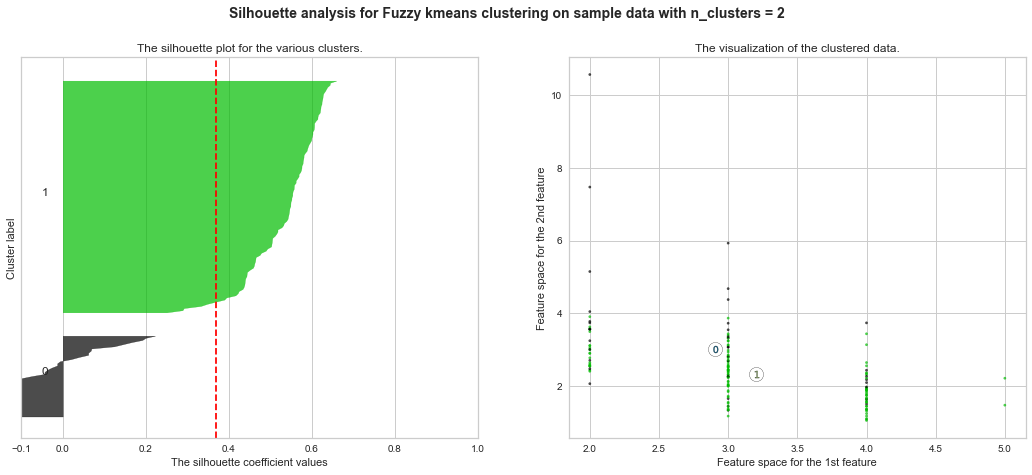

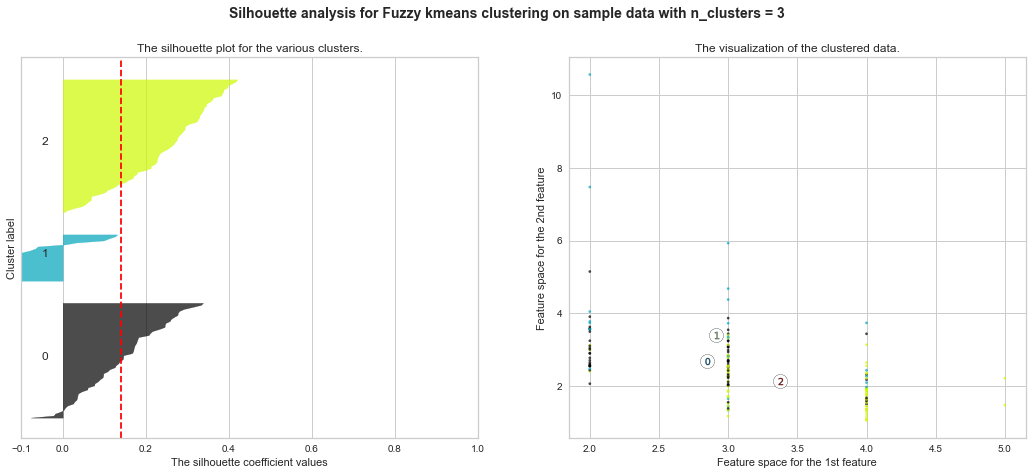

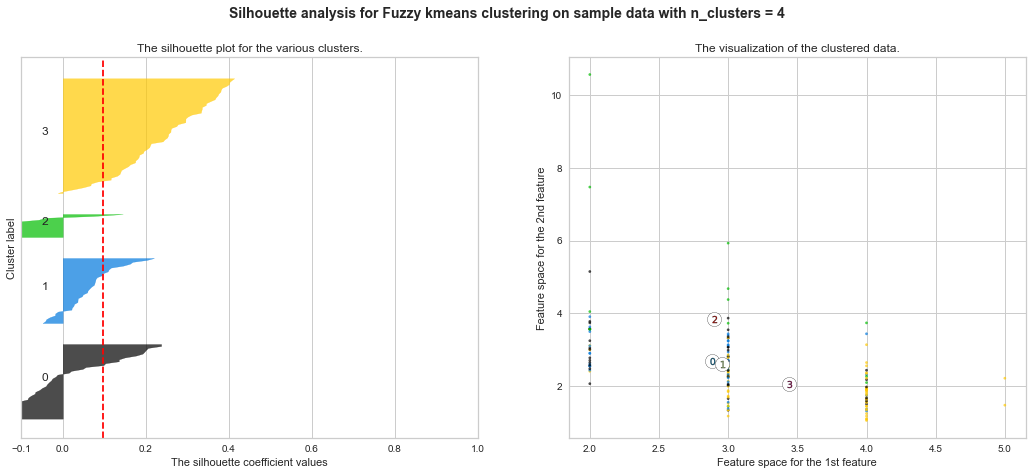

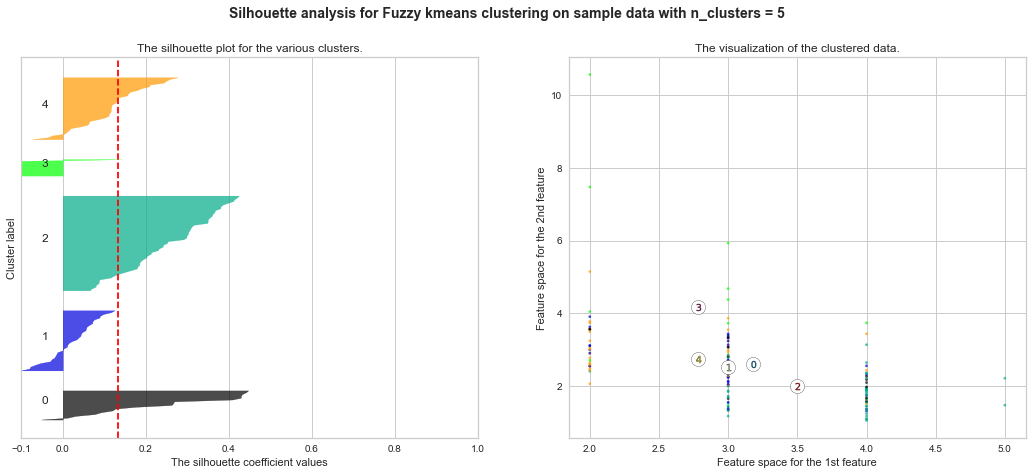

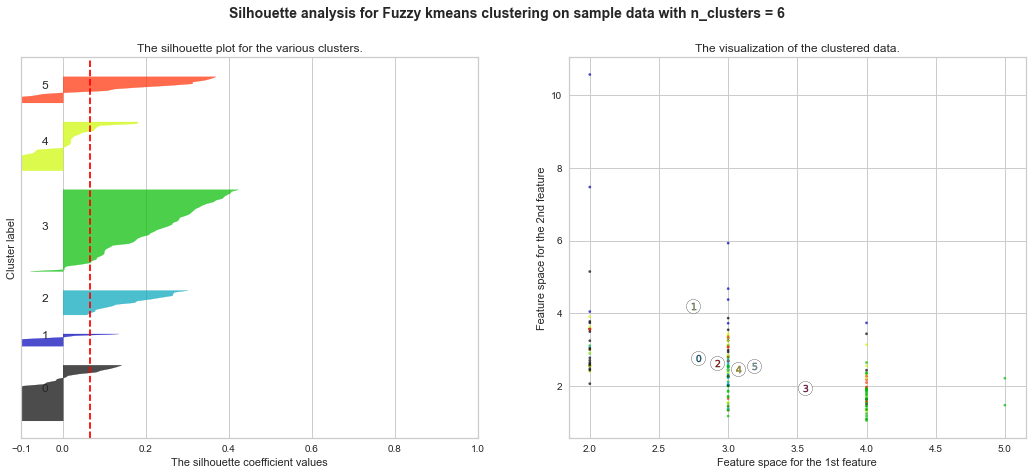

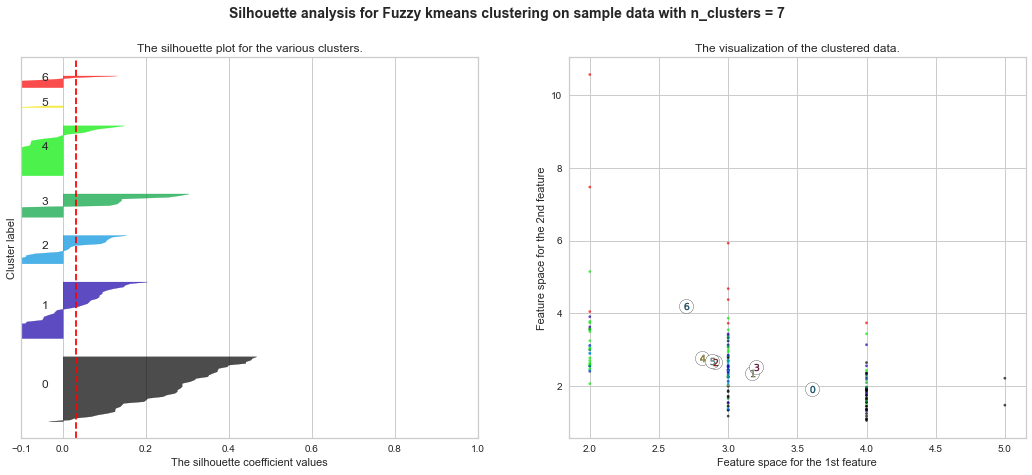

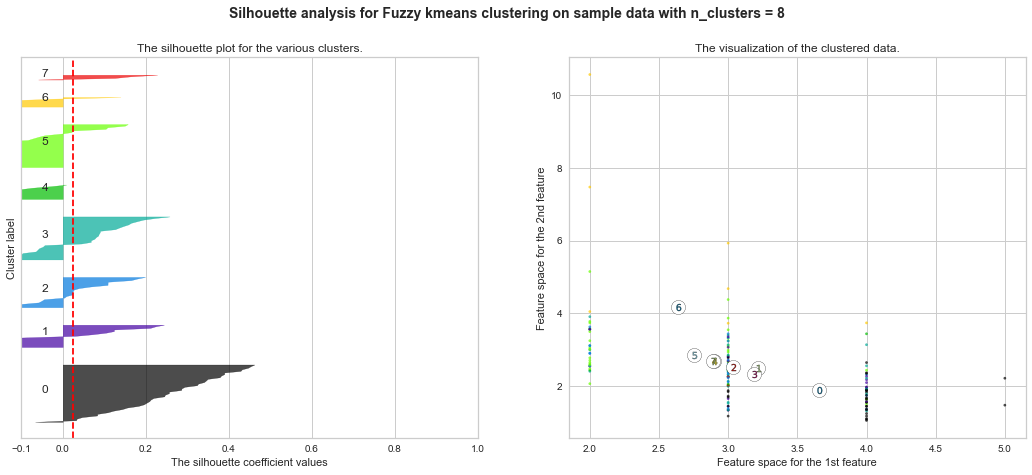

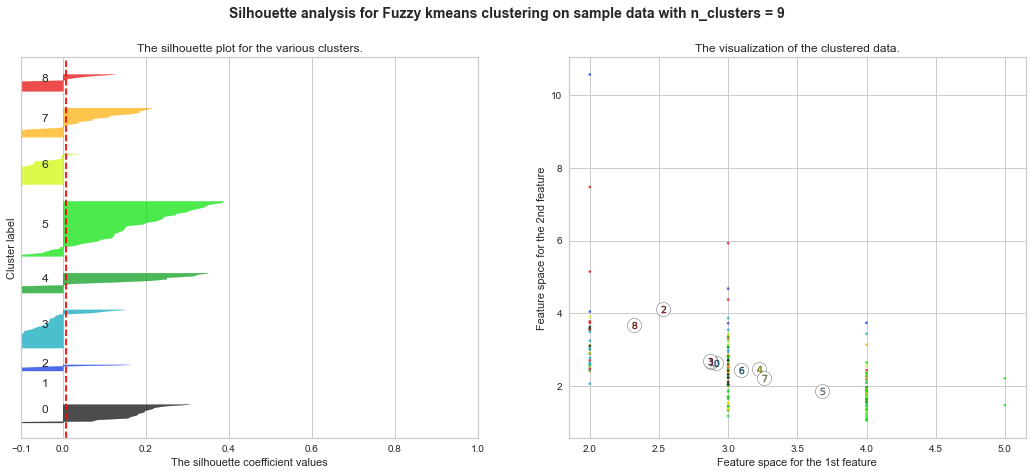

In [74]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    fuzzy_kmeans = FuzzyKMeans(n_clusters, m=2).fit(X)
    clusterer = fuzzy_kmeans.cluster_centers_
    cluster_labels = fuzzy_kmeans.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Fuzzy kmeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()